# MicroGrad Implementation

This will be an automatic differentiation module just as micrograd implemented following the tutorial by Andrej Karpathy on the subject.

https://www.youtube.com/watch?v=VMj-3S1tku0&t=102s&ab_channel=AndrejKarpathy

In [1]:
import traceback
import math

class Value():
    """
    This class wraps a simple numeric value and will keep track of all the operations that created such value. \\
    This will be done by implementing a directed graph where the nodes will be the previous values and they will be connected \\
    to another parent value through a mathematical operation like `+`, `-`, `*`, `\`, `**`, etc. As such, we will implement operator \\
    overloading in this class so one can generate new Value objects when one of the above operations are performed. 
    """

    def __init__(self, data, children: list=[], op: str='') -> None:
        self.data = data
        self.children = children
        self.op = op
        self.grad = 0.0
        self.backward = lambda: None
        

    def __repr__(self) -> str:
        return f'Value(data={self.data}, op={self.op})'

    def backprop(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            # print(f'Nodo: {node.data} op: {node.op}, grad: {node.grad}')
            node.backward()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, children=[self, other], op='+')

        def backward():
            # print(f"Self {self.data}: {self.grad}, other {other.data}: {other.grad}, out {out.data}: {out.grad}")
            self.grad += (1.0 * out.grad)
            other.grad += (1.0 * out.grad)
            
        
        out.backward = backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data - other.data, children=[self, other], op='-')

        def backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
            
        
        out.backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, children=[self, other], op='*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        
        out.backward = backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data / other.data, children=[self, other], op='/')

        def backward():
            self.grad += (1 / other.data) * out.grad
            other.grad += (- self.data / other.data**2) * out.grad
            
        
        out.backward = backward
        return out

    def __rtruediv__(self, other):
        return self**(-1) * other

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, children=[self, other], op='**')

        def backward():
            self.grad += (other.data * self.data ** (other.data - 1)) * out.grad
            # Have to be carefull with this one since a^x when a < 0 has complex values and is not really differentiable
            # other.grad += (math.log(self.data) * self.data ** other.data  ) * out.grad
            
        
        out.backward = backward
        return out
    
    def __neg__(self): # -self
        return self * -1

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, children=[self], op='tanh')

        def backward():
            self.grad += (1 - t**2) * out.grad

        out.backward = backward
        return out

    def relu(self):
        x = self.data
        t = max((0, x))
        out = Value(t, children=[self], op='relu')
        
        def backward():
            self.grad += (0 if out.data <= 0 else 1) * out.grad

        out.backward = backward
        return out



In [2]:
a =  Value(6)
b = Value(3)
print(a, b)
print(a + b)
print(a - b)
print(a * b)
print(a / b)
print(a ** b)

Value(data=6, op=) Value(data=3, op=)
Value(data=9, op=+)
Value(data=3, op=-)
Value(data=18, op=*)
Value(data=2.0, op=/)
Value(data=216, op=**)


In [2]:
from graphviz import Digraph
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    l = [var_name for var_name, var_val in callers_local_vars if var_val is var]

    return l[-1] if len(l) > 0 else '**'

def trace(root):
    nodes, edges = [], set()
    def build(v):
        if v not in nodes:
            nodes.append(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def torch_trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges



def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left-to-Right Graph

    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=' %s | data %.4f | grad %.4f ' % (retrieve_name(n), n.data, n.grad), shape='record')

        if n.op:
            dot.node(name = uid + n.op, label=n.op)
            dot.edge(uid + n.op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    return dot

Now lets test the graphing function with some simple operations

In [4]:
a =  Value(2)
b = Value(3)
c = a + b
d = c + a

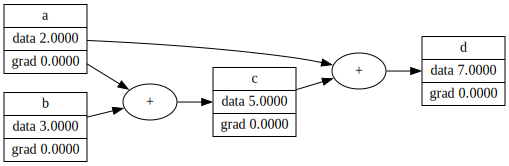

In [5]:
draw_dot(d)

Now we will check if the backwards propagation immplementation works. The next example is the same as in the video tutorial, but the implementation of backprop in the `Value` class is made recursively calling `backwards()` on the nodes whereas in the video tutorial they make a topological sort of the graph and then call `backward()`in the sort order. At the ende of the day is the same thing since the topological sort is also implemented recursively traversing through the graph 

In [6]:
x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

t = (x1 * w1) + (x2 * w2) + b
o = t.tanh()

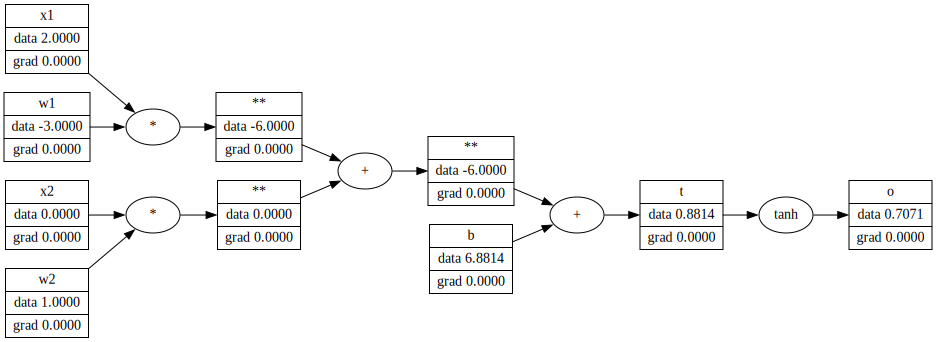

In [7]:
draw_dot(o)

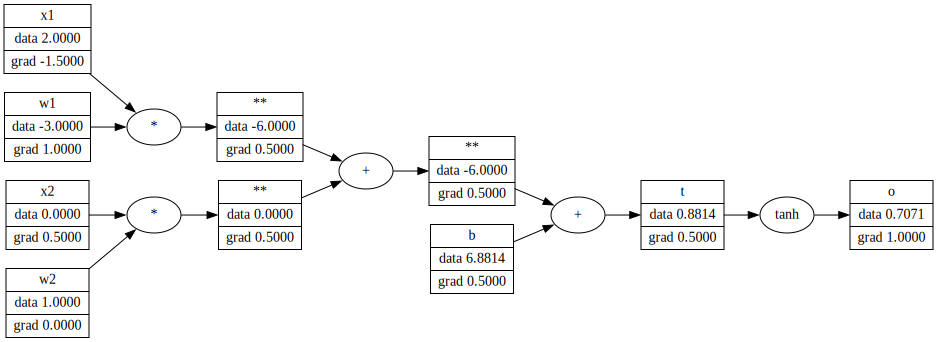

In [8]:
o.backprop()
draw_dot(o)

Testing against Pytorch Iplementation

In [9]:
import torch

def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backprop()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    draw_dot(xmg)

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item(), f"Wrong calculation of backward pass. Should be {xpt.grad.item()} but received {xmg.grad}"

def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backprop()
    amg, bmg, gmg = a, b, g

         

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

test_sanity_check()
test_more_ops()

Lets create a Simple Neural Net Module

In [12]:
from tqdm import tqdm
import random

random.seed(0.1)

class Neuron():

    def __init__(self, size, activation='relu') -> None:

        self.size = size
        self.w = [Value(data=((random.random()) * 0.1)) for i in range(self.size)]
        self.b = Value(data=0.0)
        self.activation = activation

        self.parameters = self.w + [self.b]

    def forward(self, x):
        a = sum([wi *  xi for wi, xi in zip(self.w, x)], self.b)
        return a.relu() if self.activation == 'relu' else (a.tanh() if self.activation == 'tanh' else a)


class LinearLayer():

    def __init__(self, input_size, output_size, activation='relu') -> None:

        self.W = [Neuron(input_size, activation) for i in range(output_size)]
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation

        self.parameters = []
        for neuron in self.W:
            self.parameters.extend(neuron.parameters)
    
    def forward(self, x):
        assert len(x) == self.input_size, f"The sizes don't match. Expected {self.input_size} but got {len(x)}"
        return [neuron.forward(x) for neuron in self.W]

    def __repr__(self) -> str:
        return f'Linear Layer: Input_size: {self.input_size}, Output_size: {self.output_size}, Activation: {self.activation}  |'

class NeuralNet():

    def __init__(self, sizes, activations='relu') -> None:

        assert isinstance(activations, str) or (isinstance(activations, list) and len(activations) == (len(sizes) - 1)), "The activations must be either the same for all layer (a single string) or a list of strings the same size as the number of layers - 1"

        self.activations = []
        if isinstance(activations, str):
            self.activations = [activations] * (len(sizes) - 2)
            self.activations.append('')
        else:
            self.activations = activations
        # print(self.activations)

        self.net = [LinearLayer(sizes[i], sizes[i + 1], self.activations[i])  for i in range(len(sizes) - 1)]
        self.sizes = sizes
        self.parameters = []
        for ll in self.net:
            self.parameters.extend(ll.parameters)

    def forward(self, x):

        for ll in self.net:
            x = ll.forward(x)

        return x
    
    def zero_grad(self):
        for param in self.parameters:
                param.grad = 0

    def backward(self, X, Y, loss_fn, epochs=20, lr=0.05):
        losses = []
        accuracy = []
        final_loss = ''

        for i in tqdm(range(epochs)):
            # Forward Pass
            Y_hat = [self.forward(x)[0] for x in X]

            # Loss function
            loss, acc, _ = loss_fn(Y_hat, Y)
            losses.append(loss.data)
            accuracy.append(acc)
            final_loss = loss

            # Zero the gradients
            self.zero_grad()

            # Backward Pass
            loss.backprop()

            # Optimization
            for param in self.parameters:
                lr = 1 -  0.96*i/epochs
                param.data += -lr * param.grad

        return losses, accuracy, final_loss



    def __repr__(self) -> str:
        repr_str = '---------------------------------------------------------------------\n'*2
        for i, ll in enumerate(self.net):
            repr_str += f'| {i}| {ll} \n'
        repr_str += '--------------------------------------------------------------------\n'
        return repr_str
        


Try it on a dataset

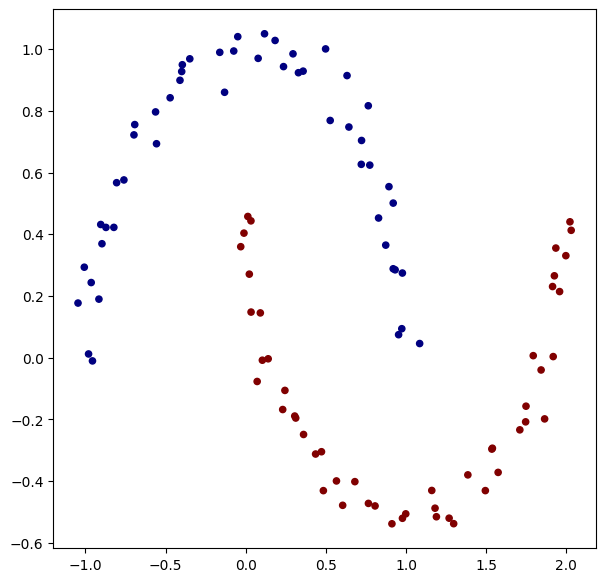

In [4]:
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X, y = make_moons(n_samples=100, noise=0.05)
y = y*2 - 1
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [13]:
activations = ['tanh', 'tanh', '']
net = NeuralNet([2, 16, 16, 1], activations)
print(net)
print(f'Number of parameters: {len(net.parameters)}')

---------------------------------------------------------------------
---------------------------------------------------------------------
| 0| Linear Layer: Input_size: 2, Output_size: 16, Activation: tanh  | 
| 1| Linear Layer: Input_size: 16, Output_size: 16, Activation: tanh  | 
| 2| Linear Layer: Input_size: 16, Output_size: 1, Activation:   | 
--------------------------------------------------------------------

Number of parameters: 337


In [14]:
def max_margin_loss(Y_hat, Y):
    # forward the model to get scores
    # print(Y_hat)
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(Y, Y_hat)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in net.parameters))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(Y, Y_hat)]
    return total_loss, sum(accuracy) / len(accuracy), accuracy

In [15]:
%%time
losses, accuracy, l = net.backward(X, y, max_margin_loss, epochs=100, lr=0.15)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

CPU times: total: 1min 35s
Wall time: 1min 35s


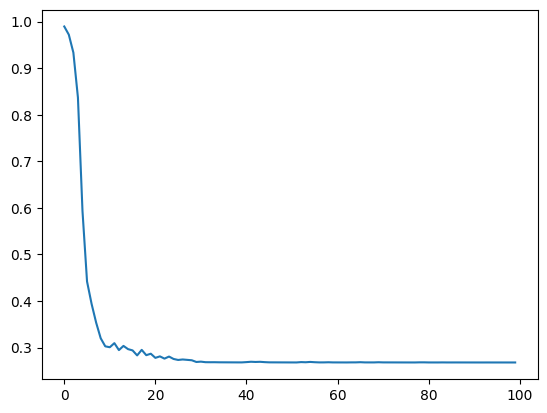

In [16]:
plt.plot(losses)

0.88


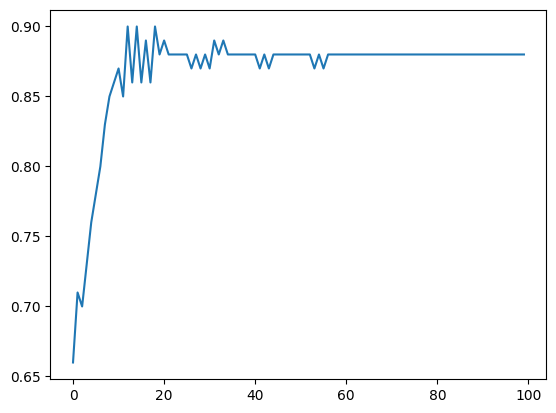

In [17]:
print(accuracy[-1])
plt.plot(accuracy)

(-1.5383283789807003, 1.9616716210192997)

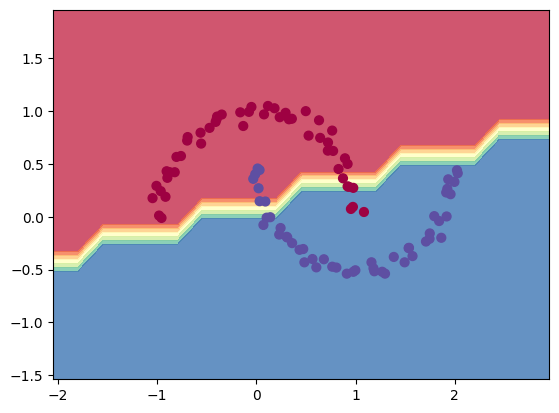

In [18]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = [net.forward(i)[0] for i in inputs]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [171]:
draw_dot(l)